In [1]:
import os
import json
import math
import requests
import pandas as pd
from datetime import datetime
from dotenv import load_dotenv
import warnings

warnings.filterwarnings('ignore')

# Аналитика по резюме выпускников

## Подготовка к работе

Вся ниже представленная информация базируется на возможностях предоставляемых [HeadHunter API](https://dev.hh.ru/).

До начала работы **важно понимать**, что Вам потребуется аккаунт пользоваться, которые идентифицируется HH как работодатель. Это может быть как корпоративный аккаунт от университета (в рамках HH есть центральный HR-аккаунт, который может регистрировать новых корпоративных пользователей), так и совсем сторонний работодатель, с точки зрения забора данных это не важно. **Дополнительных финансовых вложений не потребуется**, мы будем использовать только данные резюме, которые требуют только авторизации как работодатель.

Дополнительно к аккаунту от работодателя Вам потребуется зарегистрировать приложение для работы с API. Авторизуйтесь (зарегистрировать приложение можно под личным аккаунтом на HH, но рекомендую, для порядку, делать это всё из под одной корпоративной учётки) в [личном кабинете разработчика](https://dev.hh.ru/admin) и зарегистрируйте новое приложение. По моему опыту процесс одобрения приложения со стороны HH не превышает одной недели.

После регистрации приложения у него появятся следующие реквизиты: `Client ID`, `Client Secret`, `Токен приложения`. Это позволит Вам авторизовать пользователя и получить реквизиты для работы с API. Сам процесс авторизации неплохо описан самим HeadHunter в [статье на Habr-е](https://habr.com/ru/companies/hh/articles/303168/). Обратите внимание, что токен авторизации пользователя имеет время жизни, его придётся периодически обновлять.

Надеюсь у Вас **всё получится** по выше описанному!

### ID университетов в HH

Для поиска ID-шников университетов, которые мы будем использовать для работы с API, вы можете использовать 3 способа:

1. [«Ручку» API HH](https://api.hh.ru/openapi/redoc#tag/Podskazki/operation/get-educational-institutions-suggests) для поиска по учебным заведениям. Вот [пример ссылки](https://api.hh.ru/suggests/educational_institutions?text=%D0%98%D0%A2%D0%9C%D0%9E) для поиска «ИТМО»;
2. [«Ручку» API psal.ru](https://app.psal.ru/api/university/), с данными об университетах, которые отслеживаются проектом (на момент написания, апрель 2023 года, это университеты входящие в 2 федеральных программы «Приоритет 2030» и «Передовые инженерные школы»);
3. Ещё можно воспользоваться [расширенным поиском](https://hh.ru/search/resume/advanced) на самом hh.ru, где есть UI-ки для указания учебного заведения. Вы можете воспользоваться DevTool браузера и при поиске/выборе учебного заведения, забирать необходимое Вам ID университета (см. gif-ку с иллюстрацией).

Я буду использовать вариант упомянутый в пункте 2 и для полноты картины остановлюсь на некоторых моментах:

1. У университетов есть филиалы, но в используемом API psa.ru используется только ID головных организаций. Пример с [МФТИ](https://api.hh.ru/suggests/educational_institutions?text=%D0%9C%D0%A4%D0%A2%D0%98), как это бывает.
2. Данные HH видимо не всегда поспевают за переименованиями университетов, и проходилось отлавливать университеты по старым названиям. Из того с чем столкнулся, при поиске ID-шников: «Уральский государственный медицинский университет» — «Уральская государственная медицинская академия»; «Смоленский государственный медицинский университет» — «Смоленская государственная медицинская академия»; «Тихоокеанский государственный медицинский университет» — «Владивостокский государственный медицинский университет».
3. Университеты объединяются, в этом случае в API psa.ru используется ID одной из объединённых организаций, если в данных HH нет ещё нового университета. Конкретный пример — для «Уфимский университет науки и технологий» используется «Башкирского государственного университета».
4. По каким-то причинам мне не удалось найти в HH «Университет Иннополис».

## Исходные данные об университетах

Сформируем таблицу университетов с основными данными и ID для работы с HH API.

In [2]:
# Функция для работы с API https://app.psal.ru/api
def get_results_from_api(url, page=1):
    results = pd.DataFrame()

    resp = requests.get(url + f"?page={page}")

    if resp.status_code == 200:
        json_data = resp.json()
        results = pd.concat([results, pd.json_normalize(json_data['results'])], ignore_index=True)

        if json_data['next']:
            next_page_df = get_results_from_api(url, page + 1)
            results = pd.concat([results, next_page_df], ignore_index=True)
    else:
        return pd.DataFrame()

    return results

In [3]:
# Формируем таблицу со списком университетов
universities = get_results_from_api('https://app.psal.ru/api/university/')
universities = universities[universities['deleted_at'].isnull()]
universities = universities.apply(lambda x: pd.concat([
    x[list(filter(lambda y: y in ['id', 'title_short', 'title_display', 'domain', 'educational_institution_id'], x.keys()))],
    pd.Series({'educational_institution_id': x['hh'][0]['educational_institution_id']})
]), axis=1)
universities = universities[~universities['educational_institution_id'].isnull()]
universities['educational_institution_id'] = universities['educational_institution_id'].astype(int)
universities.head(5)

,id,title_short,title_display,domain,educational_institution_id
0,1,Адыгейский государственный университет,АГУ,adygnet.ru,41900
1,2,Алтайский государственный университет,АлтГУ,asu.ru,41808
2,3,Амурский государственный университет,АмГУ,amursu.ru,42650
3,4,Астраханский государственный университет,АГУ им. В.Н. Татищева,asu.edu.ru,40229
5,6,Белгородский государственный технологический у...,БГТУ,bstu.ru,45479


## Забираем резюме из HH по нашим университетам

Для начала настроим всё, что нам понадобится дла работы с HH API.

In [4]:
load_dotenv('../.env')
access_token = os.getenv('HH_ACCESS_TOKEN_USER')
session = requests.session()
session.headers.update({'Authorization': f"Bearer {os.getenv('HH_ACCESS_TOKEN_USER')}"})
# Расшифровка GET-параметров в запросе
# area - регион поиска (113 - вся Россия)
# educational_institution - id-конкретного университета
# job_search_status - кандидаты находятся в активном поиске
# relocation - живут или готовы к релокации из региона
# order_by - сортируем по ожидаемой заработной плате
# period - 1 день (ниже см. почему выбран именно такой период)
# per_page - кол-во результатов на странице ответа
# page - номер страницы в выдаче
# text - возможность поиска по текстам вакансии, но мы её игнорируем
search_query = '''
/resumes?
area=113
&educational_institution={edu_inst_id}
&job_search_status=active_search
&relocation=living_or_relocation
&order_by=salary_desc
&period=1
&per_page={per_page}
&page={page}
&text=
'''.replace('\n', '')

# Функция для работы с API HH
def get_data(edu_inst_id, page=0, per_page=100) -> list:
    url = f"https://api.hh.ru{search_query.format(edu_inst_id=edu_inst_id, per_page=per_page, page=page)}"
    resp = session.get(url)
    resumes = []

    if resp.status_code == 200:
        json_data = resp.json()
        total = json_data['found']
        count_of_page = math.ceil(total / per_page)
        resumes += json_data['items']

        if count_of_page != page + 1:
            resumes += get_data(edu_inst_id, page + 1)
    else:
        print(f'{url} returned status code {resp.status_code}')

    return resumes

Далее сходим в API и сохраним результаты по каждому университету в отдельный json-файл. Потребуется временя, процесс можно отслеживать в папке `data/json_from_hh_api/`, куда сохраняются результирующие json-чики. В конце посмотрим ТОП-10 университетов по количеству резюме их выпускников на данный момент.

In [5]:
resume_by_universities = pd.DataFrame()

for i, u in universities.iterrows():
    educational_institution_id = u['educational_institution_id']
    university_title = u['title_display']
    resume_by_university = get_data(educational_institution_id)
    file_path = f"data/resume/{educational_institution_id}.json"

    with open(file_path, 'w') as f:
        json.dump(resume_by_university, f, ensure_ascii=False, indent=4)

    resume_by_universities = pd.concat([resume_by_universities, pd.DataFrame([{
        'title_display': u['title_display'],
        'educational_institution_id': educational_institution_id,
        'resume_count': len(resume_by_university),
        'file_path': file_path
    }])], ignore_index=True)

resume_by_universities.sort_values(by='resume_count', ascending=False).head(10)

https://api.hh.ru/resumes?area=113&educational_institution=42253&job_search_status=active_search&relocation=living_or_relocation&order_by=salary_desc&period=1&per_page=100&page=20&text= returned status code 400
https://api.hh.ru/resumes?area=113&educational_institution=43555&job_search_status=active_search&relocation=living_or_relocation&order_by=salary_desc&period=1&per_page=100&page=20&text= returned status code 400


,title_display,educational_institution_id,resume_count,file_path
109,РАНХиГС,39639,843,data/resume/39639.json
107,ВШЭ,39307,568,data/resume/39307.json
43,РЭУ им. Г.В. Плеханова,38958,563,data/resume/38958.json
51,СПбПУ,39765,416,data/resume/39765.json
72,УРФУ,43473,416,data/resume/43473.json
25,МГТУ им. Н.Э. Баумана,38921,399,data/resume/38921.json
46,РУДН,39271,387,data/resume/39271.json
87,РУТ (МИИТ),39532,337,data/resume/39532.json
29,МПГУ,39337,332,data/resume/39337.json
81,КФУ,43555,300,data/resume/43555.json


## Работа с полученными данными

Отдельно **обращу внимание**, что, например, выпускники РАНХиГС генерят за 1 день, около 1 тыс. резюме. При этом у HH есть ограничение в 2 тыс. записей, который они отдают по запросу (это касается как API, так и UI-ек на их сайте). По этим причинам в данном примере и используется 1 день в GET-параметре `period`, чтобы влезть в это ограничение и ничего не упустить.

Теперь на нескольких примерах пробежимся по 🤩 **впечатляющему объёму данных**, которые у нас получились. Очень надеюсь, что аналитики университетов зацепятся за эту возможность и попробуют более глубоко изучить своих выпускников.

Для начало соберём всё в один dataframe и отобразим получившееся кол-во строк:

In [6]:
all_resume = pd.DataFrame()

for i, u in resume_by_universities.iterrows():
    json_by_university = json.load(open(u['file_path'], 'r'))
    df_by_university = pd.json_normalize(json_by_university)
    df_by_university['title_display'] = u['title_display']
    all_resume = pd.concat([all_resume, df_by_university], ignore_index=True)

len(all_resume)

17144

### Заработные платы выпускников

Самое очевидное это **заработная плата** и просто для примера, выстроим университеты по медиане ожидаемой заработной платы выпускников. Оговорюсь, что реальной ценности такого подхода «в лоб» нет или он даже вредный, т.к. построения рейтинга нужно учитывать региональность, область полученного образования и ещё ряд факторов, для обзора возможности данных сойдёт 👌

In [7]:
all_resume[
    # Используем только заработные платы в рублях (лень было пересчитывать валюты 🤷‍♂️)
    (all_resume['salary.currency'] == 'RUR') &
    # Исключаем резюме без заработной платы
    (~all_resume['salary.amount'].isnull()) &
    # Смотрим только резюме с ЗП выше или равно МРОТ (на апрель 2023 г.)
    (all_resume['salary.amount'] >= 13890)
][['title_display', 'salary.amount']].groupby(by='title_display').median().sort_values(by='salary.amount', ascending=False).head(10)

,salary.amount
title_display,
МФТИ,150000.0
МГИМО,120000.0
РАМ им. Гнесиных,111500.0
НИУ МГСУ,110000.0
ТГМУ,110000.0
УГНТУ,100000.0
ВШЭ,100000.0
МИРЭА,100000.0
МГТУ им. Н.Э. Баумана,100000.0


### Количество образований в резюме

Резюме отобраны по факту вхождения одного из университетов в список образовательных организаций, которые указаны в резюме, т.е. конкретный университет из нашего списка, может и бывает далеко не единственный и на этой базе прям многое можно выжать.

Начнём с банального рейтинга университетов по средней длине списка образовательных организаций, в которые они входят (выводим ТОП-10).

In [8]:
all_resume['edu_count'] = all_resume['education.primary'].apply(lambda x: len(x))
all_resume[['title_display', 'edu_count']].groupby(by='title_display').mean().sort_values(by='edu_count', ascending=False).head(10)

,edu_count
title_display,
ПИМУ,2.555556
ВМА,2.500000
МГМСУ,2.370968
РНИМУ,2.362069
ПСПбГМУ,2.310345
МГППУ,2.275862
РАНХиГС,2.265718
МГИМО,2.237500
БГМУ,2.185185


### Резюме обучающихся

Данные позволяют нам отсеять из общей массы резюме обучающихся и посмотреть, например, сколько их (выведем ТОП-10 по количеству):

In [9]:
all_resume['is_student'] = all_resume['education.primary'].apply(lambda x: len(x) == 1 and x[0]['year'] > datetime.now().year)
all_resume[all_resume['is_student']][['title_display', 'is_student']].groupby(by='title_display').count().sort_values(by='is_student', ascending=False).head(10)

,is_student
title_display,
ВШЭ,57
РАНХиГС,51
МГТУ им. Н.Э. Баумана,38
СПбПУ,34
УРФУ,32
КФУ,31
РУДН,28
ИТМО,24
РУТ (МИИТ),22


### Какую работу ищут выпускники

В данных присутствует предполагаемое кандидатами название должности. Попробуем сгруппировать данные для одного из университетов и посмотреть ТОП 10.

In [10]:
resume_by_etu = all_resume[all_resume['title_display'] == 'СПбГЭТУ «ЛЭТИ»'][['title_display', 'title', 'url']]
resume_by_etu_and_title = resume_by_etu.groupby(by=['title_display', 'title'], as_index=False).count().rename(columns={'url': 'count'}).sort_values(by='count', ascending=False)
resume_by_etu_and_title.head(10)

,title_display,title,count
13,СПбГЭТУ «ЛЭТИ»,Frontend-разработчик,4
109,СПбГЭТУ «ЛЭТИ»,Руководитель отдела продаж,2
91,СПбГЭТУ «ЛЭТИ»,Менеджер проекта,2
38,СПбГЭТУ «ЛЭТИ»,Python Developer,2
69,СПбГЭТУ «ЛЭТИ»,Инженер,2
98,СПбГЭТУ «ЛЭТИ»,Начинающий специалист,2
28,СПбГЭТУ «ЛЭТИ»,Junior Python Developer,2
8,СПбГЭТУ «ЛЭТИ»,Data scientist,2
82,СПбГЭТУ «ЛЭТИ»,Копирайтер,1
83,СПбГЭТУ «ЛЭТИ»,"Куратор, копирайтер",1


И взглянем на конец списка:

In [11]:
resume_by_etu_and_title.tail(10)

,title_display,title,count
45,СПбГЭТУ «ЛЭТИ»,Sales,1
44,СПбГЭТУ «ЛЭТИ»,QA инженер,1
43,СПбГЭТУ «ЛЭТИ»,QA engineer,1
42,СПбГЭТУ «ЛЭТИ»,QA Engineer (Junior),1
41,СПбГЭТУ «ЛЭТИ»,QA Engineer,1
40,СПбГЭТУ «ЛЭТИ»,Python developer,1
39,СПбГЭТУ «ЛЭТИ»,Python backend разработчик,1
37,СПбГЭТУ «ЛЭТИ»,Project Manager,1
36,СПбГЭТУ «ЛЭТИ»,Product manager,1
124,СПбГЭТУ «ЛЭТИ»,"руководитель, инженер по КИПиА",1


Из-за того что название текстовое поле, кандидаты указывают там слишком уникальные значения. Нужно что-то более нормализированное для такого анализа. Для этого придётся сходить в каждую вакансию и получить более [подробную информацию по резюме](https://api.hh.ru/openapi/redoc#tag/Vakansii/operation/get-vacancy). **Обратите внимание**, что API отдаёт намного больше расширенной информации.

In [12]:
json_with_full_info_by_etu = []

# Тут мы упираемся видимо в бесплатные возможности API, которое отдаёт подробную информацию только по 50 резюме
for i, r in resume_by_etu[:50].iterrows():
    resp_full_info = session.get(r['url'])

    if resp_full_info.status_code == 200:
        json_with_full_info_by_etu.append(resp_full_info.json())

resume_full_by_etu = pd.json_normalize(json_with_full_info_by_etu)
resume_full_by_etu[['title', 'professional_roles']].head(10)

,title,professional_roles
0,DevOps engineer / SRE,"[{'id': '96', 'name': 'Программист, разработчи..."
1,"(Ведущий) Менеджер по продукту, Менеджер проектов","[{'id': '10', 'name': 'Аналитик'}, {'id': '73'..."
2,Менеджер проекта,"[{'id': '104', 'name': 'Руководитель группы ра..."
3,Руководитель отдела разработки,"[{'id': '107', 'name': 'Руководитель проектов'..."
4,"Начальник отдела, начальник сектора","[{'id': '16', 'name': 'Аудитор'}]"
5,Электрик,"[{'id': '40', 'name': 'Другое'}, {'id': '143',..."
6,QA инженер,"[{'id': '124', 'name': 'Тестировщик'}]"
7,Product manager,"[{'id': '107', 'name': 'Руководитель проектов'..."
8,Java developer,"[{'id': '96', 'name': 'Программист, разработчи..."
9,Преподаватель английского языка (Native),"[{'id': '132', 'name': 'Teacher, educator'}, {..."


Ели нет возможности расшить деньгами ограничение в 50 вакансий с подробной информацией... есть запасной вариант 👍 Для этого придётся сначала сформировать справочник по имеющимся [профессиональным ролям](https://github.com/hhru/api/blob/master/docs/role_catalog_article.md) и при начальном сборе информации по университетам обходить API по каждой профессиональной роли указывая её в GET параметре `professional_role`.

### Банальные цифры

В данных есть пол, можно взглянуть на эти данные по конкретному университету:

In [13]:
pd.pivot_table(
    all_resume[['title_display', 'gender.id', 'id']],
    index='title_display',
    columns='gender.id',
    values='id',
    aggfunc='count',
).sort_values(by='male', ascending=False).head(10)

gender.id,female,male
title_display,,
РАНХиГС,360.0,483.0
МГТУ им. Н.Э. Баумана,86.0,313.0
РЭУ им. Г.В. Плеханова,280.0,283.0
СПбПУ,147.0,269.0
ВШЭ,306.0,262.0
УРФУ,166.0,250.0
РУТ (МИИТ),122.0,215.0
УГНТУ,55.0,209.0
МАИ,69.0,197.0


Можно посмотреть распределение по возрасту для конкретных университетов:

array([[<Axes: title={'center': 'СПбПУ'}>,
        <Axes: title={'center': 'ИТМО'}>],
       [<Axes: title={'center': 'СПбГЭТУ «ЛЭТИ»'}>,
        <Axes: title={'center': 'ГУАП'}>]], dtype=object)

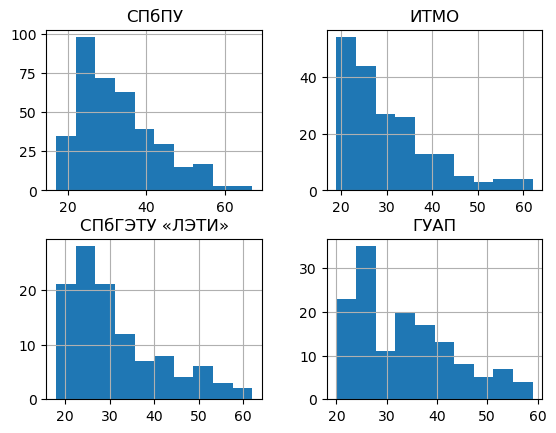

In [14]:
pd.DataFrame({
    'СПбПУ': all_resume[(all_resume['title_display'] == 'СПбПУ') & (~all_resume['age'].isnull())]['age'],
    'ИТМО': all_resume[(all_resume['title_display'] == 'ИТМО') & (~all_resume['age'].isnull())]['age'],
    'СПбГЭТУ «ЛЭТИ»': all_resume[(all_resume['title_display'] == 'СПбГЭТУ «ЛЭТИ»') & (~all_resume['age'].isnull())]['age'],
    'ГУАП': all_resume[(all_resume['title_display'] == 'ГУАП') & (~all_resume['age'].isnull())]['age']
}).hist(bins=10)

### Куда выпускники идут учиться после

В завершении посмотрим что-то более сложное и менее очевидное. Данные об образовании позволяют изучить последовательность получения образования, на базе этого можно попробовать сделать какие-нибудь не на столько очевидные выводы. Посмотрим, где получают последующее образования выпускники одного из университетов.

In [15]:
universities_by_id = universities.set_index('educational_institution_id')
university_for_research = universities[universities['title_display'] == 'РАНХиГС'].iloc[0].T
next_edu = pd.DataFrame()

for i, r in all_resume[all_resume['title_display'] == university_for_research['title_display']].iterrows():
    is_completed_edu = False

    for edu in r['education.primary']:
        if edu['name_id'] == str(university_for_research['educational_institution_id']) and edu['year'] <= datetime.now().year:
            is_completed_edu = True
        elif is_completed_edu and edu['name_id'] != str(university_for_research['educational_institution_id']):
            next_edu = pd.concat([next_edu, pd.DataFrame([{
                'next_edu_id': edu['name_id'],
                'next_edu_title': edu['name']
            }])])

next_edu.groupby(by='next_edu_title', as_index=False).count().rename(columns={'next_edu_id': 'count'}).sort_values(by='count', ascending=False).head(10)

,next_edu_title,count
276,"Национальный исследовательский университет ""Вы...",10
351,Российский экономический университет им. Г.В. ...,10
241,Московский государственный университет им. М.В...,9
342,Российский государственный университет нефти и...,8
238,Московский государственный технологический уни...,8
235,Московский государственный технический универс...,7
468,Финансовый университет при Правительстве Росси...,7
200,Московская Государственная юридическая академи...,7
348,"Российский университет дружбы народов, Москва",6
225,"Московский государственный горный университет,...",6


## Вместо выводов

Очень надеюсь, что мне удалось продемонстрировать, в первом приближении, возможности данных, которые вы можете самостоятельно получить из API HH. Как мне кажется задача, анализа своих выпускников, на базе объективных данных, должна быть одной из основных задач аналитических подразделений внутри университетов. А после отработки инструментария можно пробовать выходить на региональный или федеральный уровень.

P.S. Объём данных такой, что у меня нет технической возможности постоянно забирать их и строить Dashboard-ы на основании полученных данных, по аналогии с 📊 [вакансиями университетов](https://datalens.yandex/qv1g5xwqyzysg) 🤷‍♂️